## How to efficiently load images?

In [1]:
import fastai
from fastai import *
from fastai.vision import *
import utils  # person functions
import os
%matplotlib inline

In [2]:
# global variables
restart_run = True                 # start from scratch
labels='train_stratified_split.csv'
padding_mode='border'
param_baseline = {'experiment': 'baseline', 
                  'image_size': 224, 
                  'batch_size': 32, 
                  'num_workers':0, 
                  'folder':'train'}

In [3]:
def load_train_image(data):
    'Just load the data and nothing else'
    for i, batch in enumerate(data.train_dl): 
        pass

def get_data(params):
    'wrapper function for parameter settings'
    return utils.get_data(size=param['image_size'], 
                          bs=param['batch_size'], 
                          csv=labels, 
                          folder=param['folder'], 
                          num_workers=param['num_workers'], 
                          padding_mode=padding_mode)

In [4]:
tfms = get_transforms(flip_vert=False, max_zoom=1);
[i.tfm.name for i in tfms[0]]  # transformation done on training data set

['TfmCrop', 'TfmPixel', 'TfmCoord', 'TfmAffine', 'TfmLighting', 'TfmLighting']

In [5]:
# first step is to resize the image
vision.transform._crop_pad??

Signature:
vision.transform._crop_pad(
    x,
    size,
    padding_mode='reflection',
    row_pct: <function uniform at 0x7f0db521e0d0> = 0.5,
    col_pct: <function uniform at 0x7f0db521e0d0> = 0.5,
) -> fastai.vision.image.Image
Docstring: <no docstring>
Source:   
def _crop_pad(x, size, padding_mode='reflection', row_pct:uniform = 0.5, col_pct:uniform = 0.5):
    f_crop_pad = _crop_pad_image_points if isinstance(x, ImagePoints) else _crop_pad_default
    return f_crop_pad(x, size, padding_mode, row_pct, col_pct)
File:      ~/anaconda3/lib/python3.7/site-packages/fastai/vision/transform.py
Type:      function


In [6]:
if utils.data_fp.exists() & ~restart_run:
    exp_param = pd.read_csv(utils.data_fp/'loading_runtime.csv')
else:
    exp_param = pd.DataFrame(columns=['experiment', 'image_size', 'batch_size', 'num_workers', 'folder', 'avg', 'stdev'])

## Baseline: Loading unprocessed images
How long does it take to load images from a dataloader with all the transformation?

In [7]:
param = param_baseline.copy()

should insert code to warm up the cpu before running test that will be recorded. 

In [8]:
result = %timeit -n1 -r3 -o load_train_image(get_data(param))

5min 50s ± 10.7 s per loop (mean ± std. dev. of 3 runs, 1 loop each)


In [9]:
param['avg'], param['stdev'] = result.average, result.stdev

In [10]:
exp_param = exp_param.append(param, ignore_index=True)

Each time I restart my computer, I rerun below code to warm the computer up and to see how much variance there are with the timing. 

In [11]:
param = param_baseline.copy()
param['experiment'] = 'baseline2'
result = %timeit -n1 -r3 -o load_train_image(get_data(param))
param['avg'], param['stdev'] = result.average, result.stdev
exp_param = exp_param.append(param, ignore_index=True)

5min 43s ± 187 ms per loop (mean ± std. dev. of 3 runs, 1 loop each)


## Experiment 1: Number of workers
How does the number of worker impact loading of the data?  
Are there a limit before overhead becomes not worth it?

In [12]:
workers_ls = [1,2,3,4,5,6,defaults.cpus,20]
param = param_baseline.copy()
param['experiment'] = 'number of workers'

In [13]:
for x in workers_ls:
    print(f'Workers: {x}')
    param['num_workers'] = x
    result = %timeit -n1 -r3 -o load_train_image(get_data(param))
    param['avg'], param['stdev'] = result.average, result.stdev
    exp_param = exp_param.append(param, ignore_index=True)

Workers: 1
5min 59s ± 739 ms per loop (mean ± std. dev. of 3 runs, 1 loop each)
Workers: 2
3min 7s ± 262 ms per loop (mean ± std. dev. of 3 runs, 1 loop each)
Workers: 3
2min 15s ± 134 ms per loop (mean ± std. dev. of 3 runs, 1 loop each)
Workers: 4
1min 49s ± 196 ms per loop (mean ± std. dev. of 3 runs, 1 loop each)
Workers: 5
1min 36s ± 387 ms per loop (mean ± std. dev. of 3 runs, 1 loop each)
Workers: 6
1min 29s ± 313 ms per loop (mean ± std. dev. of 3 runs, 1 loop each)
Workers: 12
1min 21s ± 20.2 ms per loop (mean ± std. dev. of 3 runs, 1 loop each)
Workers: 20
1min 21s ± 129 ms per loop (mean ± std. dev. of 3 runs, 1 loop each)


In [14]:
compare = exp_param[exp_param.experiment.isin(['baseline', 'number of workers'])];
compare = compare.pivot('num_workers', 'experiment', ['avg', 'stdev'])/60; 
compare

avg                      stdev                  
experiment   baseline number of workers baseline number of workers
num_workers                                                       
0            5.838139               NaN  0.17804               NaN
1                 NaN          5.997388      NaN          0.012318
2                 NaN          3.123635      NaN          0.004359
3                 NaN          2.260051      NaN          0.002225
4                 NaN          1.828755      NaN          0.003260
5                 NaN          1.605044      NaN          0.006452
6                 NaN          1.483398      NaN          0.005219
12                NaN          1.355906      NaN          0.000336
20                NaN          1.357462      NaN          0.002154

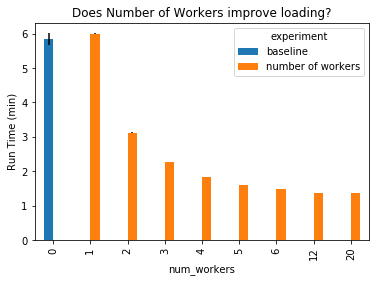

In [15]:
ax = compare.avg.plot(kind='bar', yerr=[compare.stdev.baseline, compare.stdev['number of workers']])
ax.set_title('Does Number of Workers improve loading?')
ax.set_ylabel('Run Time (min)');

In [16]:
# Rerun number of workers = 1 because to double check that the increase is true. 
param = param_baseline.copy()
param['num_workers'] = 1
%timeit -n1 -r3 load_train_image(get_data(param))

6min 1s ± 260 ms per loop (mean ± std. dev. of 3 runs, 1 loop each)


**Conclusion**: Yes, number of workers does improve loading. However, the improvement greatly decrease after value is 2. Interestingly setting number of workers to 1 takes longer. 

## Experiment 2: Batch Size

Batch size shouldn't impact the time because the amount of work is the same. But what if there is an interaction between num_workers and batch_size. Larger batchsize allow for better use of subprocess?

In [17]:
batch_ls = [1, 8, 16, 32, 64, 128]
param = param_baseline.copy()
param['experiment'] = 'batch_size'

num_worker = 0, the cpu usage is 50%. 

In [18]:
for x in batch_ls:
    print(f'Batch Size: {x}')
    param['batch_size'] = x
    result = %timeit -n1 -r3 -o load_train_image(get_data(param))
    param['avg'], param['stdev'] = result.average, result.stdev
    exp_param = exp_param.append(param, ignore_index=True)

Batch Size: 1
5min 49s ± 623 ms per loop (mean ± std. dev. of 3 runs, 1 loop each)
Batch Size: 8
5min 42s ± 3.2 s per loop (mean ± std. dev. of 3 runs, 1 loop each)
Batch Size: 16
5min 44s ± 305 ms per loop (mean ± std. dev. of 3 runs, 1 loop each)
Batch Size: 32
5min 44s ± 1.06 s per loop (mean ± std. dev. of 3 runs, 1 loop each)
Batch Size: 64
5min 45s ± 662 ms per loop (mean ± std. dev. of 3 runs, 1 loop each)
Batch Size: 128
5min 47s ± 832 ms per loop (mean ± std. dev. of 3 runs, 1 loop each)


In [19]:
compare = exp_param[exp_param.experiment.isin(['baseline', 'batch_size'])];
compare = compare.pivot('batch_size', 'experiment', ['avg', 'stdev'])/60; compare

avg               stdev           
experiment  baseline batch_size baseline batch_size
batch_size                                         
1                NaN   5.818094      NaN   0.010385
8                NaN   5.702935      NaN   0.053393
16               NaN   5.744699      NaN   0.005083
32          5.838139   5.742056  0.17804   0.017598
64               NaN   5.762257      NaN   0.011032
128              NaN   5.795878      NaN   0.013865

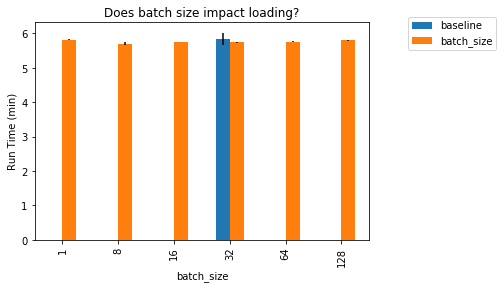

In [20]:
ax = compare.avg.plot(kind='bar', yerr=[compare.stdev.baseline, compare.stdev.batch_size])
ax.set_title('Does batch size impact loading?')
ax.set_ylabel('Run Time (min)')
ax.legend(bbox_to_anchor=(1.1, 1.05));

Conclusion: I do not think this was a good experiment because using just the main processor, pytorch probably doesn't have enough flexibility to improve load time to be noticable. 

## Experiment 3: Batch size plus number of workers
Since experiment 1 tested batch size of 32 and range of workers, this will just test with a larger batch size with the same range of workers. 

In [21]:
param = param_baseline.copy()
param['experiment'] = 'batch_size_plus_workers'
param['batch_size'] = 128   # it is unlikely my gpu will be able to fit larger batch than this

In [22]:
for x in workers_ls:
    print(f'Workers: {x}')
    param['num_workers'] = x
    result = %timeit -n1 -r3 -o load_train_image(get_data(param))
    param['avg'], param['stdev'] = result.average, result.stdev
    exp_param = exp_param.append(param, ignore_index=True)

Workers: 1
6min 2s ± 328 ms per loop (mean ± std. dev. of 3 runs, 1 loop each)
Workers: 2
3min 9s ± 357 ms per loop (mean ± std. dev. of 3 runs, 1 loop each)
Workers: 3
2min 18s ± 665 ms per loop (mean ± std. dev. of 3 runs, 1 loop each)
Workers: 4
1min 52s ± 104 ms per loop (mean ± std. dev. of 3 runs, 1 loop each)
Workers: 5
1min 38s ± 707 ms per loop (mean ± std. dev. of 3 runs, 1 loop each)
Workers: 6
1min 31s ± 437 ms per loop (mean ± std. dev. of 3 runs, 1 loop each)
Workers: 12
1min 23s ± 101 ms per loop (mean ± std. dev. of 3 runs, 1 loop each)
Workers: 20
1min 24s ± 176 ms per loop (mean ± std. dev. of 3 runs, 1 loop each)


In [23]:
compare = exp_param[exp_param.experiment.isin(['number of workers', 'batch_size_plus_workers'])]
compare = compare.pivot('num_workers', 'batch_size', ['avg', 'stdev'])/60; compare

avg               stdev          
batch_size        32        128       32        128
num_workers                                        
1            5.997388  6.041024  0.012318  0.005475
2            3.123635  3.161080  0.004359  0.005942
3            2.260051  2.303759  0.002225  0.011081
4            1.828755  1.866907  0.003260  0.001727
5            1.605044  1.645682  0.006452  0.011783
6            1.483398  1.528368  0.005219  0.007282
12           1.355906  1.395024  0.000336  0.001687
20           1.357462  1.402802  0.002154  0.002933

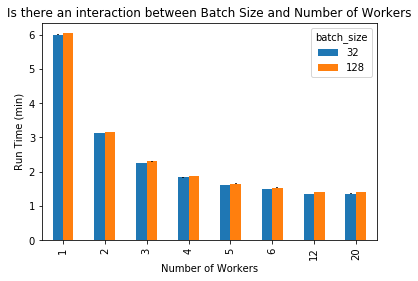

In [24]:
compare.avg.plot(kind='bar', yerr=[compare.stdev[32], compare.stdev[128]])
plt.title('Is there an interaction between Batch Size and Number of Workers')
plt.xlabel('Number of Workers')
plt.ylabel('Run Time (min)');

## Experiment 4: Preprocess image by resizing and saving the result

### Saving images as 224x224

In [25]:
dest = utils.data_fp/'train_224'
dest.mkdir(parents=True, exist_ok=True)
il = ImageImageList.from_folder(utils.data_train)  # get the list of images in train folder

In [26]:
def resize_tfms(fn, i):
    img = vision.open_image(fn)
    img = img.apply_tfms([vision.crop_pad()], size=224, resize_method=ResizeMethod.PAD, padding_mode='border')
    img.save(dest/fn.name)

In [27]:
%%time 
fastai.callback.parallel(resize_tfms, il.items)  # num_workers = default.cpus which is 12

CPU times: user 13.1 s, sys: 2.05 s, total: 15.2 s
Wall time: 9min 41s


In [28]:
!du -sh ./data/train
!du -sh ./data/train_224

4.3G	./data/train
244M	./data/train_224


### Test loading

In [29]:
param = param_baseline.copy()
param['experiment'] = 'resized_image2'
param['folder'] = 'train_224'
param['num_workers'] = 4

In [30]:
result = %timeit -n1 -r3 -o load_train_image(get_data(param))

1min 50s ± 31.1 ms per loop (mean ± std. dev. of 3 runs, 1 loop each)


In [31]:
param['avg'], param['stdev'] = result.average, result.stdev
exp_param = exp_param.append(param, ignore_index=True)

In [32]:
compare = exp_param[(exp_param.batch_size == 32) & (exp_param.num_workers == 4)].sort_values('experiment');
compare

,experiment,image_size,batch_size,num_workers,folder,avg,stdev
5,number of workers,224,32,4,train,109.725322,0.195592
24,resized_image2,224,32,4,train_224,110.046879,0.031076


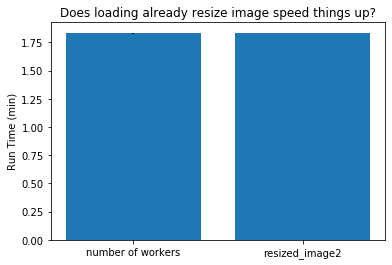

In [33]:
plt.bar(compare.experiment, compare.avg/60, yerr=compare.stdev/60)
plt.title('Does loading already resize image speed things up?')
plt.ylabel('Run Time (min)');

**Conclusion**: Saving resized image did not decrease the time it takes to load in the images. 

### Experiment 4b: just loading a image

In [34]:
%timeit -n3 -r3 img=vision.open_image(il.items[0])

13.2 ms ± 505 µs per loop (mean ± std. dev. of 3 runs, 3 loops each)


In [35]:
!rm -rf {dest}  # train_224 is no longer needed

## Experiment 5: Preprocess image by resizing and saving the result with **4K images**

It is possible that the images aren't big enought to test the load and saving benefit. So let's try 4k images. 

### Diversity of whales' images

In [36]:
shapes = []
for img in il.items:
    shapes.append(PIL.Image.open(img).size)

In [37]:
pd.Series(shapes).value_counts()[:10]  # top 10 shape for whales images

(1050, 700)    3330
(1050, 600)    2549
(1050, 450)    1556
(1050, 525)    1303
(700, 500)      667
(1050, 591)     280
(1050, 701)     265
(1000, 667)     177
(879, 584)      148
(1050, 750)     136
dtype: int64

In [38]:
np.random.seed(42)
il_3 = il.items[np.random.randint(0,len(il.items),3)]

In [39]:
for fn in il_3:
    print(f'==== {fn.name} : {PIL.Image.open(fn).size} : {os.path.getsize(fn)/1e6:.2f} mb ===')
    %timeit -n3 -r3 np.array(PIL.Image.open(fn))

==== 73c51f3da.jpg : (1050, 450) : 0.17 mb ===
7.41 ms ± 721 µs per loop (mean ± std. dev. of 3 runs, 3 loops each)
==== 116e1a7b7.jpg : (1050, 630) : 0.25 mb ===
10.4 ms ± 150 µs per loop (mean ± std. dev. of 3 runs, 3 loops each)
==== d552620fd.jpg : (1050, 450) : 0.14 mb ===
6.56 ms ± 12.6 µs per loop (mean ± std. dev. of 3 runs, 3 loops each)


### 4K stats and load time

Chose 3 random images from online to have a variety of images with different color scheme.

In [40]:
il_4k = ImageList.from_folder(utils.data_fp/'large_images')

In [41]:
for fn in il_4k.items:
    print(f'==== {fn.name} : {PIL.Image.open(fn).size} : {os.path.getsize(fn)/1e6:.0f} mb ===')
    %timeit -n3 -r3 np.array(PIL.Image.open(fn))

==== hutton-4k.jpg : (3840, 2160) : 5 mb ===
190 ms ± 2.85 ms per loop (mean ± std. dev. of 3 runs, 3 loops each)
==== arp299_4k.jpg : (5760, 3240) : 11 mb ===
416 ms ± 3.48 ms per loop (mean ± std. dev. of 3 runs, 3 loops each)
==== saitama-4k.jpg : (3676, 2631) : 6 mb ===
196 ms ± 515 µs per loop (mean ± std. dev. of 3 runs, 3 loops each)
==== hutton-4k.jpg : (224, 224) : 0 mb ===
659 µs ± 35.7 µs per loop (mean ± std. dev. of 3 runs, 3 loops each)
==== arp299_4k.jpg : (224, 224) : 0 mb ===
607 µs ± 18.8 µs per loop (mean ± std. dev. of 3 runs, 3 loops each)
==== saitama-4k.jpg : (224, 224) : 0 mb ===
769 µs ± 20.4 µs per loop (mean ± std. dev. of 3 runs, 3 loops each)


### 4k save as 224x224

In [42]:
dest = utils.data_fp/'large_images'/'images_224'
dest.mkdir(parents=True, exist_ok=True)

In [43]:
%%time 
fastai.callback.parallel(resize_tfms, il_4k.items)  # num_workers = default.cpus which is 12

CPU times: user 767 ms, sys: 208 ms, total: 975 ms
Wall time: 1.14 s


In [44]:
for fn in ImageList.from_folder(dest).items:
    print(f'==== {fn.name} : {PIL.Image.open(fn).size} : {os.path.getsize(fn)/1e3:.0f} kb ===')
    %timeit -n3 -r3 np.array(PIL.Image.open(fn))

==== hutton-4k.jpg : (224, 224) : 7 kb ===
842 µs ± 157 µs per loop (mean ± std. dev. of 3 runs, 3 loops each)
==== arp299_4k.jpg : (224, 224) : 4 kb ===
624 µs ± 38.1 µs per loop (mean ± std. dev. of 3 runs, 3 loops each)
==== saitama-4k.jpg : (224, 224) : 13 kb ===
774 µs ± 21.5 µs per loop (mean ± std. dev. of 3 runs, 3 loops each)


**Conclusion**: Yes, saving larger image into a smaller size will help train by reducing load time. However, the image needs to big or else it doesn't help at all. For instance, whale images where reduce by ~15x in size and that didn't help. While 4k images were reduce by ~166x and the load decrease by ~200x. I think there is a size threshold as well because of overhead before we can see the benefit of saving images in reduce size. 

## Experiment 6: Loading from disk vs ram?

I tried selecting for 8k of images. Loading that many images went beyond 16 gb of ram. 1k images takes around 6gb. 

In [45]:
images_fn = il.items[:1000]  # test on 1k images

### Loading from disk

In [46]:
%%timeit -n3 -r3 
for fn in images_fn:
    img = vision.open_image(fn)
    img = img.apply_tfms([vision.crop_pad()], size=224, resize_method=ResizeMethod.PAD, padding_mode='border')

15.5 s ± 43.6 ms per loop (mean ± std. dev. of 3 runs, 3 loops each)


### Loading from ram

In [47]:
%timeit -n3 -r3 [vision.open_image(fn) for fn in images_fn]

9.06 s ± 136 ms per loop (mean ± std. dev. of 3 runs, 3 loops each)


In [48]:
images_ram = [vision.open_image(fn) for fn in images_fn]

In [49]:
%%timeit -n3 -r3
for img in images_ram:
    img = img.apply_tfms([vision.crop_pad()], size=224, resize_method=ResizeMethod.PAD, padding_mode='border')

6.54 s ± 9.44 ms per loop (mean ± std. dev. of 3 runs, 3 loops each)


In [50]:
del images_ram

**Conclusion**: It does look like loading the images into ram does help reduce the loading of images but the amount of space in ram required is signficantly higher than on disk. So it is unlikely to be able to use this trick unless you have a really small dataset. 

## Export result

In [51]:
exp_param

,experiment,image_size,batch_size,num_workers,folder,avg,stdev
0,baseline,224,32,0,train,350.288349,10.682400
1,baseline2,224,32,0,train,343.515173,0.187487
2,number of workers,224,32,1,train,359.843272,0.739077
3,number of workers,224,32,2,train,187.418105,0.261557
4,number of workers,224,32,3,train,135.603078,0.133503
5,number of workers,224,32,4,train,109.725322,0.195592
6,number of workers,224,32,5,train,96.302654,0.387131
7,number of workers,224,32,6,train,89.003867,0.313115
8,number of workers,224,32,12,train,81.354347,0.020156
9,number of workers,224,32,20,train,81.447743,0.129215


In [52]:
exp_param.to_csv(utils.data_fp/'loading_runtime.csv', index=False)

### Hardware of current system

In [53]:
hardware_info = !lshw -short -sanitize
for line in hardware_info:
    for word in ['WARNING','Description', '==', 'processor', 'memory', 'display']:
        if word in line: print(line)

H/W path              Device   Class       Description
/0/0                           memory      15GiB System memory
/0/1                           processor   AMD Ryzen 5 1600 Six-Core Processor
/0/100/1.3/0.2/4/0             display     GP106 [GeForce GTX 1060 6GB]
/0/100/3.1/0                   display     GP106 [GeForce GTX 1060 6GB]
